---
## <font color='blue'> 0. 필요 패키지 불러오기</font>

필요한 라이브러리들을 불러옵니다.

In [2]:
import os
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm
import time


import random
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
import pickle
import os

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score


warnings.filterwarnings("ignore")

---
## <font color='blue'> 1. 하이퍼파라미터 설정</font>

모델 학습 및 데이터 로드에 사용되는 인자값들을 미리 설정해둡니다.  

In [3]:
args = {
    "EXCEL_PATH": './data/전기로(1월~4월)rev.xlsx', # 제공받은 엑셀 파일 데이터입니다.(석사님이 보내주신 원본 데이터)
    "MODEL_SAVE_PATH": './model',                # 학습 후 모델을 pickel 파일 형식으로 저장할 때, 저장할 경로입니다. pickel은 파이썬에서 제공하는 모듈로 쉽게 모델을 저장해놓고 불러올 수 있더라구요.
    "RESULT_PATH": './result',                   # 모델 학습 결과(0(출강X) 혹은 1(출강) 여부)를 저장할 경로입니다.
    "SCALER_PATH": './scaler',                   # 학습 시 정규화를 위해 계산된 학습 데이터의 칼럼별 평균 및 표준편차 정보를 저장할 경로입니다. 
    "PREV": 3,                                   # 석사님이 주신 데이터에서 실제 출강 시점 이전 PREV 분 까지도 출강 시점으로 설정하겠다는 값입니다. 
    "POST": 1,                                   # 마찬가지로 출강 시점 POST 분까지 출강시점으로 설정하겠다는 값입니다. 
    "FOLD_NUM": 5,                               # 5번의 교차 검증으로 모델 성능을 평가합니다.
    "MODE": 'train_split',                       # train 모드입니다(train, test 모드를 나눴는데, 여기서는 크게 의미 없습니다!)
    "TEST_SIZE": 0.2,                            # 전체 데이터의 20%를 테스트셋으로 설정합니다.
    "RANDOM_SEED": 42,                           # 시드를 고정합니다.
    "DROP_COLS": ["천정 냉각수 유량"]                # 리스트 내의 이름을 갖고 있는 칼럼을 제거할 수 있도록 하였습니다. 
}

---
## <font color='blue'> 2. 엑셀 파일 로드</font>
* `load_data` 함수입니다.

엑셀 파일을 불러온 후, 먼저 불필요한 칼럼부터 제거합니다.(스크랩 종류 및 양 ~ 데이터명까지 총 4개 칼럼. 이 칼럼들은 값이 비어있어서 그냥 빼줬던 것으로 기억합니다.)

그 밑으로는, 칼럼 이름을 보기 좋게 처리하고(line 9), 시간 칼럼은 시간 분단위까지만 표시하게끔 하였습니다.(line 10)

In [4]:
# 엑셀 데이터 로드 함수
def load_data(args):
    """
    :param args: args.py의 하이퍼파라미터
    :return: '스크랩 종류 및 양', '부원료', 'Unnamed: 0', '데이터명'등의 불필요 칼럼은 제거하고, '스크랩 종류 및 량' 시트와 merge한 데이터프레임(df)을 반환합니다.
    """
    df = pd.read_excel(args["EXCEL_PATH"], sheet_name=0, header=7) # rows : 155805 | Heats : 2209(1~4월 데이터 기준)
    df = df.drop(['스크랩 종류 및 양', '부원료', 'Unnamed: 0', '데이터명'], axis=1)        # 불필요 칼럼 제거  
    df.columns = list(df.columns[:4]) + [x.split('\n')[0] for x in df.columns[4:]] # 칼럼 이름 변경
    df['시간'] = df['시간'].apply(lambda x: x.round(freq='T')) # 시간 칼럼 처리 

    scrap = pd.read_excel(args["EXCEL_PATH"], sheet_name=1, header=1) # 스크랩 데이터 불러오기
    scrap = scrap.rename(columns={"HEAT": "히트NO."})  # 칼럼 이름 변경
    scrap["총사용량"] = scrap["총사용량"] * 0.001 # kg -> t   # kg 단위를 톤으로 바꿨습니다.
    scrap = scrap.drop(["Unnamed: 0", "조", "생산량", "일자", "강종", "강종명", "강종구분"], axis=1) # 여기서도 예측에 사용되지 않는 칼럼들 제거
    scrap = scrap.fillna(0.0) # 비어있는 값을 0으로 채웠습니다. 스크랩에서 비어있는 값은 실제로 0을 의미하더라구요(투입되는 양이 0이라는 뜻)
    scrap = scrap.iloc[:, :2] # 스크랩 데이터프레임에서는 스크랩 총사용량 변수만 가져와서 사용합니다.(이후 히트별로 전력사용량을 각각의 전체 스크랩 투입량으로 나누는 전력사용량_NORMALIZED 파생변수를 만들 때 사용됩니다.)
    
    df = pd.merge(df, scrap, on='히트NO.', how='left')
    
    return df

In [5]:
print("Data Loading ...")
df = load_data(args)  # 전처리된 데이터프레임을 불러옵니다.
df.head() 

# 분석에 필요한 칼럼들과 데이터가 처리되었습니다.
# 세틀링 챔버 유량, 백필터 온도 등 NaN값이 있는데, 추후에 이 칼럼들도 제거합니다.

Data Loading ...


,히트NO.,시간,T.T.T,2차장입 후 시간,전력사용량,로체냉각수유량,로체 입구온도,로체 출구온도,천정 냉각수 유량,천정 입구온도,천정 출구온도,수냉덕트 유량,수냉덕트 입구온도,수냉덕트 출구온도,세틀링 챔버 유량,공냉덕트 입구온도,백필터 온도,EBT_OPEN,출강온도,총사용량
0,4F3452,2021-01-08 16:24:00,66,0.0,0.0,640.0,21.0,21.0,428.0,21.0,26.0,1600,21.0,23.0,NaN,NaN,NaN,0,1583,130.6
1,4F3452,2021-01-08 16:25:00,66,0.0,0.0,640.0,21.0,21.0,428.0,21.0,26.0,1600,21.0,23.0,NaN,175.833951,NaN,0,1583,130.6
2,4F3452,2021-01-08 16:26:00,66,0.0,0.0,640.0,21.0,21.0,427.0,21.0,25.0,1600,21.0,23.0,NaN,162.490734,NaN,0,1583,130.6
3,4F3452,2021-01-08 16:27:00,66,0.0,0.0,639.0,21.0,21.0,427.0,21.0,25.0,1600,21.0,23.0,NaN,148.851001,NaN,0,1583,130.6
4,4F3452,2021-01-08 16:28:00,66,0.0,0.0,639.0,21.0,21.0,425.0,21.0,24.0,1600,21.0,23.0,NaN,134.914752,NaN,0,1583,130.6


---
## <font color='blue'> 3. 전력사용량 기준 전처리 & EBT_OPEN 값 설정 & 새로운 변수 추가</font>

* `elec_preprocess_total` : 전력사용량 전처리
* `ebt_preprocess` : EBT_OPEN 전처리
* `feature_engineering` : 새로운 변수 추가 함수



전처리 함수입니다.

먼저 elec_preprocess_total 함수를 통해 앞에서 전처리된 데이터프레임을 다시 처리해줍니다. elec_preprocess_total 함수 안에 ebt_preprocess, feature_engineering함수가 같이 쓰이는 형태입니다.

이 함수를 통해 전력사용량 기준으로 찾은 비정상적인 히트들을 찾아서 제거합니다.

그리고 남아있는 히트들을 통해 저희의 타겟값인 출강여부(EBT_OPEN)를 기준으로 앞 3행, 뒤 1행을 출강시점(1)로 처리해주게 됩니다.
        
그리고 ebt_preprocess 함수를 거쳐서 EBT_OPEN 타겟값을 한개에서 5개로 늘려줬고(데이터 불균형 문제를 다 해결한건 아니지만, 도메인 지식이 있는 클라이언트인 석사님의 의견을 통해 실제 출강 시점 3분전, 1분후까지는 괜찮을 것 같다는 의견을 바탕으로 이렇게 처리해주었습니다.),

feature_engineering 함수를 통해서 파생 변수를 추가해줬습니다. 

그리고 마지막으로 불필요 칼럼들을 제거하는 코드가 추가되어 있습니다.

In [20]:
def elec_preprocess_total(df, args):
    """
    :param df: 불러온 엑셀 데이터를 입력받습니다.
    :param args: args.py의 하이퍼파라미터
    :return: 전력사용량 및 EBT_OPEN 전처리한 데이터프레임을 반환합니다.
    """
    total = None
    names = df['히트NO.'].unique()
    for idx, name in tqdm(enumerate(names), total=len(names)):
        temp = df[df['히트NO.'] == name].reset_index(drop=True)
        
        # 처음 10행에서 전력사용량의 절댓값이 20보다 작은 경우의 index 값 가져오기
        bool_idx_1 = temp['전력사용량'][:10].apply(lambda x: np.abs(x) < 20)
        
        # 전력사용량이 20보다 큰 경우가 있으면, 20보다 작은 행만 가져오기.
        if sum(bool_idx_1 == False) != 0:
            temp = pd.concat([temp[:10][bool_idx_1], temp[10:]], axis=0).reset_index(drop=True)
        else:
            pass
        
        # 전력변화량 변수 추가
        temp["전력변화량"] = temp['전력사용량']-temp['전력사용량'].shift(1).fillna(0)
        
        # 전력변화량이 7보다 큰 경우 index 값 가져오기
        bool_idx_2 = temp['전력변화량'].apply(lambda x: np.abs(x) > 7)
        
        # bool_idx_2(전력변화량 7보다 큰 경우)가 한개 이상이면, 그 행 이전까지만 데이터 잘라내기
        if sum(bool_idx_2) != 0:
            temp = temp.iloc[:bool_idx_2[bool_idx_2 == True].index[0], :]
            
        # 자르고 난 후, 데이터 길이기 30 미만인 히트면 제거
        if len(temp) < 30:
            continue
        
        # 첫 행의 전력사용량이 10 이하인 히트만 가져오기
        temp = temp.reset_index(drop=True)
        if temp.loc[0, '전력사용량'] > 10:
            continue
        
        # EBT_OPEN 전처리
        temp = ebt_preprocess(temp, prev=args["PREV"], post=args["POST"])
        
        # Feature Engineering
        temp = feature_engineering(temp)
        
        if idx == 0:
            total = temp
        else:
            total = pd.concat([total, temp], axis=0)
    
    # 학습에 사용하지 않을 변수 제거
    total = total.drop(["T.T.T",        # 출강 전까지 알 수 없는 변수입니다.
                        "2차장입 후 시간",  # 시각화 결과, 정확하지 않은 값들이 많았습니다.
                        "로체냉각수유량",    # 대부분의 값이 630이었고, 학습에 큰 도움이 되지 않았습니다.
                        "수냉덕트 유량",    # 모든 값이 1600이었습니다.
                        "세틀링 챔버 유량",  # 분단위로 거의 바뀌지 않는 값이었습니다. 또한 결측치가 많았습니다.(29756개)
                        "백필터 온도",      # 결측치가 많았습니다.(54617개)
                        "출강온도",        # 출강 전까지 알 수 없는 변수입니다.
                        "시간",           # TIME이라는 변수를 따로 추가했습니다.
    ], axis=1)
    
    total = total[~total.isnull().any(axis=1)].reset_index(drop=True) # 결측치 존재하는 행 삭제
    
    return total.reset_index(drop=True)

In [21]:
# EBT_OPEN 전처리
def ebt_preprocess(temp, prev=3, post=1):
    """
    elec_preprocess_total 함수에서 사용되는 보조 함수입니다. EBT_OPEN 앞 3행, 뒤 1행을 1로 처리하는 함수입니다!(타겟값 처리)
    :param temp: 히트별 데이터프레임을 입력받습니다.
    :param prev: 최초로 EBT_OPEN=1이 되는 시점 이전 prev 행
    :param post: 최초로 EBT_OPEN=1이 되는 시점 이후 post 행
    :return: EBT_OPEN 전처리된 히트별 데이터프레임을 반환합니다.
    """
    # 초반 0~15분 내 1의 값을 갖는 EBT_OPEN은 모두 0 처리
    temp["EBT_OPEN"][:15]=0
  
    #  1의 값이 없으면, 마지막 행 prev+1개를 EBT_OPEN=1로 처리
    if temp["EBT_OPEN"].sum() == 0:
        # (prev+1)개를 1로 설정
        temp['EBT_OPEN'][-(prev+1):] = 1

    else:
        # 최초 EBT_OPEN 기준으로, 전 후 n분을 1로 설정
        temp = temp.iloc[:temp[temp["EBT_OPEN"].apply(lambda x: x == 1) == True].index[0]+(post+1)]
        temp["EBT_OPEN"][-prev-(post+1):] = 1
    return temp

In [22]:
# 변수 추가
# 위에서 스크랩
def feature_engineering(temp):
    """
    elec_preprocess_total 함수에서 사용되는 보조 함수입니다. 입출구 온도차이, 누적 온도차이값, 비율값, 변화량, 석사님이 그때 말씀하셨던 전력사용량을 정규화시키는 전력사용량_NORMALIZED 등 파생변수들을 추가했습니다.
    :param temp: 히트별 데이터프레임을 입력받습니다.
    :return: 새로운 변수가 추가된 데이터프레임을 반환합니다.
    """
    temp['로체 입출구온도차이'] = temp['로체 출구온도'] - temp['로체 입구온도']                           
    temp['천정 입출구온도차이'] = temp['천정 출구온도'] - temp['천정 입구온도']                            
    temp['수냉덕트 입출구온도차이'] = temp['수냉덕트 출구온도'] - temp['수냉덕트 입구온도']   
    temp['로체입출구온도차이_CUMSUM'] = temp["로체 입출구온도차이"].cumsum()
    temp['천정입출구온도차이_CUMSUM'] = temp["천정 입출구온도차이"].cumsum()
    temp['수냉덕트입출구온도차이_CUMSUM'] = temp["수냉덕트 입출구온도차이"].cumsum()
    temp["천정비율"] = temp["천정 입구온도"] / temp["천정 출구온도"]
    temp["로체비율"] = temp["로체 입구온도"] / temp["로체 출구온도"]
    temp["수냉덕트비율"] = temp["수냉덕트 입구온도"] / temp["수냉덕트 출구온도"]
    temp["공냉덕트입구온도변화량"] = temp['공냉덕트 입구온도']-temp['공냉덕트 입구온도'].shift(1).fillna(0)
    temp['TIME'] = range(1, len(temp)+1)   
    temp["전력사용량_NORMALIZED"] = temp["전력사용량"]/temp["총사용량"]
    temp["TIME_NORMALIZED"] = temp["TIME"]/temp["총사용량"]   

    return temp

In [23]:
total = elec_preprocess_total(df, args)

100%|██████████| 2209/2209 [00:55<00:00, 39.96it/s]


---
## <font color='blue'> 4. 변수 제거</font>
* `drop_columns` 함수

모델 성능 실험할 때 불필요 칼럼을 인자값으로 입력하면 제거되게끔 코드를 추가해놓았습니다.

In [27]:
# 변수 제거
def drop_columns(total, args):
    """
    :param total: 전체 데이터프레임을 입력받습니다.
    :param args: args.py의 하이퍼파라미터
    :return: args에서 DROP_COLS의 값이 있으면 해당 칼럼을 제거합니다.
    """
    if len(args["DROP_COLS"]) != 0:
        total2 = total.drop(args["DROP_COLS"], axis=1)
        print(f"Dropping {len(args['DROP_COLS'])} columns ...")
    else:
        total2 = total
        print("No dropping columns ...")
    return total2

In [28]:
total2 = drop_columns(total, args)
print("Data Loaded ...")

Dropping 1 columns ...
Data Loaded ...


### <font color='orange'>학습에 사용되는 칼럼 확인</font>
* `히트NO.`, `총사용량` 칼럼은 이후 `get_train_test_data` 함수에서 제거됩니다.

In [64]:
total2.columns

Index(['히트NO.', '전력사용량', '로체 입구온도', '로체 출구온도', '천정 입구온도', '천정 출구온도',
       '수냉덕트 입구온도', '수냉덕트 출구온도', '공냉덕트 입구온도', 'EBT_OPEN', '총사용량', '전력변화량',
       '로체 입출구온도차이', '천정 입출구온도차이', '수냉덕트 입출구온도차이', '로체입출구온도차이_CUMSUM',
       '천정입출구온도차이_CUMSUM', '수냉덕트입출구온도차이_CUMSUM', '천정비율', '로체비율', '수냉덕트비율',
       '공냉덕트입구온도변화량', 'TIME', '전력사용량_NORMALIZED', 'TIME_NORMALIZED'],
      dtype='object')

---
## <font color='blue'> 5. Train:Test 8:2 나누기</font>

8:2로 Train, Test 셋을 나누었습니다. 이때 단순히 row 개수로 8:2를 나누지 않고, 하나의 히트에서 이루어지는 공정을 한 묶음으로 간주하여 unique한 히트의 개수로 나누었습니다. 특정 히트가 train으로 나뉘어지면, 그 히트에 해당하는 모든 행들이 모두 train 데이터로 들어가게 됩니다.

In [34]:
def data_split(df, args):
    """
    :param df: 전처리된 데이터프레임을 입력받습니다.
    :param args: args.py의 하이퍼파라미터
    :return: 8:2로 split된 train, test 데이터셋을 반환합니다. Row 개수로 나눈 것이 아니라, 히트 개수를 기준으로 8:2로 나누었습니다.
    """
    test_size = int(df["히트NO."].nunique() * args["TEST_SIZE"])
    random.seed(args["RANDOM_SEED"])
    train_heats = random.sample(list(df["히트NO."].unique()), test_size) # 유니크 히트 개수 * 0.2를 랜덤으로 샘플링합니다.
    
    train_df = df[~df["히트NO."].isin(train_heats)].reset_index(drop=True)
    test_df = df[df["히트NO."].isin(train_heats)].reset_index(drop=True)
    
    return train_df, test_df

In [37]:
train_df, test_df = data_split(total2, args)

---
## <font color='blue'> 6. Train,Test 데이터를 모델 입력 형태로 만들기</font>
* `get_train_test_data` 함수

여기서는 이제 X와 y(EBT_OPEN 칼럼) 값을 나누어주고, 스케일링을 적용해줍니다. 스케일링은 Train셋의 각 칼럼별로 평균과 표준편차를 구해서 정규화해주었습니다. 그리고 여기서 구해진 각 칼럼별 평균과 표준편차를 Test셋에 적용해 똑같이 적용해주었습니다. Python 라이브러리인 sklearn의 `StandardScaler`를 사용했습니다.

In [40]:
def get_train_test_data(train_df, test_df, args):
    """
    :param train_df: Split된 Train 데이터셋
    :param test_df: Split된 Test 데이터셋
    :param args: args.py의 하이퍼파라미터
    :return: 모델 학습 및 검증이 가능한 형태의 train, test 데이터셋을 반환합니다(x_train, y_train, x_test, y_test).
    이때, Train데이터셋 각 칼럼별 평균 및 표준편차를 계산하여 scaler.pkl에 저장하고, 이후 Test셋 스케일링에 사용합니다.
    """
    train_df2 = train_df.drop(["히트NO.", "총사용량"], axis=1)
    test_df2 = test_df.drop(["히트NO.", "총사용량"], axis=1)

    x_train = train_df2.drop(["EBT_OPEN"], axis=1)
    y_train = train_df2["EBT_OPEN"]   
    
    x_test = test_df2.drop(["EBT_OPEN"], axis=1)
    y_test = test_df2["EBT_OPEN"]   
    
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    if not os.path.isdir(args["SCALER_PATH"]):
        os.mkdir(args["SCALER_PATH"])    
    
    pickle.dump(scaler, open(args["SCALER_PATH"]+"/scaler.pkl", 'wb'))
    print("Scaler saved ...")
    return x_train, y_train, x_test, y_test

In [41]:
x_train, y_train, x_test, y_test = get_train_test_data(train_df, test_df, args)

Scaler saved ...


---
## <font color='blue'> 7. 훈련되지 않은 모델 불러오기</font>
* `get_models` 함수


* 아래 모델들은 각각 하이퍼파라미터가 튜닝된 학습되지 않은 모델들입니다. 하이퍼 파라미터는 그리드 서치를 통해 찾은 값들입니다.
* 학습되지 않은 모델 뼈대를 먼저 불러옵니다.

In [42]:
def get_models(args):
    """
    :param args: args.py의 하이퍼파라미터
    :return: 하이퍼파라미터가 설정된 모델들을 리스트에 저장하여 반환합니다.
    """
    ran = RandomForestClassifier(random_state=args["RANDOM_SEED"],
                                 max_depth=None,
                                 max_features=0.5,
                                 min_samples_leaf=6,
                                 min_samples_split=2,
                                 n_estimators=200)
    ext = ExtraTreesClassifier(random_state=args["RANDOM_SEED"],
                               max_depth=None,
                               max_features=0.5,
                               min_samples_leaf=2,
                               min_samples_split=10,
                               n_estimators=75)
    lgbm = LGBMClassifier(random_state=args["RANDOM_SEED"],
                          num_leaves=50,
                          max_depth=6,
                          learning_rate=0.1,
                          colsample_bytree=0.8)
    xgb = XGBClassifier(random_state=args["RANDOM_SEED"],
                        objective='binary:logistic',eval_metric='logloss',
                        max_depth=3,
                        n_estimators=140)
    bag = BaggingClassifier(random_state=args["RANDOM_SEED"],
                            max_features=1.0,
                            max_samples=0.5,
                            n_estimators=200)
    gbc = GradientBoostingClassifier(random_state=args["RANDOM_SEED"],
                                     learning_rate=0.05,
                                     n_estimators=1000)
    
    model_list = [ran, ext, lgbm, xgb, bag, gbc]
    
    return model_list

In [44]:
model_list = get_models(args)
print(f"X_train : {x_train.shape}\nx_test : {x_test.shape}")
print("Training Starts ...")

X_train : (88948, 22)
x_test : (22143, 22)
Training Starts ...


---
## <font color='blue'> 8. 6개 모델 모두 훈련시키기</font>
* `train` 함수

각 모델별로 훈련을 진행합니다.

In [49]:
def train(model_list, x_train, y_train):
    """
    :param model_list: 학습이 되지 않은 모델 리스트를 입력받습니다.
    :param x_train: 학습에 사용될 독립변수를 입력받습니다.
    :param y_train: 학습에 사용될 종속변수를 입력받습니다.
    :return: 학습이 완료된 모델을 리스트에 저장하여 반환합니다.
    """
    for ind, mod in enumerate(model_list):
        a = time.time()
        mod.fit(x_train, y_train)
        print(f"{ind + 1}/{len(model_list)} {str(model_list[ind]).split('(')[0]} ... " +
              "Time: {:.1f} ...".format(time.time() - a))
    return model_list

In [50]:
model_list = train(model_list, x_train, y_train)

1/6 RandomForestClassifier ... Time: 37.0 ...
2/6 ExtraTreesClassifier ... Time: 3.0 ...
3/6 LGBMClassifier ... Time: 0.4 ...
4/6 XGBClassifier ... Time: 2.6 ...
5/6 BaggingClassifier ... Time: 46.2 ...
6/6 GradientBoostingClassifier ... Time: 180.8 ...


---
## <font color='blue'> 9. 훈련된 모델 저장하기</font>
* `save_model` 함수

훈련된 모델을 피클 형태로 저장해놓습니다.

In [51]:
# 학습한 모델 저장
def save_model(model_list, args):
    """
    :param model_list: 학습이 완료된 모델 리스트를 입력받습니다.
    :param args: args.py의 하이퍼파라미터
    :return: 따로 반환값은 없고, 함수 실행 시 학습 완료된 모델을 'MODEL_SAVE_PATH'에 'ensemble_model.pkl' 파일명으로 저장합니다.
    """
    filename = args["MODEL_SAVE_PATH"] + "/ensemble_model.pkl"
    if not os.path.isdir(args["MODEL_SAVE_PATH"]):
        os.mkdir(args["MODEL_SAVE_PATH"])    
    pickle.dump(model_list, open(filename, 'wb')) 
    print("Model saved ...")
    return

In [52]:
save_model(model_list, args)
print("Training finished ...")

Model saved ...


---
## <font color='blue'> 10. 훈련된 모델로 Test 하기</font>
* `test` 함수

Test셋을 예측합니다. 

여기서, 학습된 6개의 모델을 소프트 보팅이라고 하는 방법으로 앙상블 해주었습니다. 이는 6개의 모델로 예측된 확률값의 평균을 구하는 방식입니다. 

Decision threshold는 0.5로 설정해서, 평균 예측값이 0.5보다 크면 1(출강시점)로 예측하게 하였습니다.

In [53]:
# test
def test(model_list, x_test, y_test, test_df):
    """
    :param model_list: 학습이 완료된 모델 리스트를 입력받습니다.
    :param x_test: 검증에 사용될 독립변수를 입력받습니다.
    :param y_test: 검증에 사용될 종속변수를 입력받습니다.
    :param test_df: test셋 데이터프레임을 입력받습니다.
    :return: test_df에 모델의 예측값이 추가된 데이터프레임을 반환합니다.
    """
    p = []
    for mod in model_list:
        predict_proba = mod.predict_proba(x_test)
        p.append(predict_proba[:, 1])  # 6개의 모델로 예측되는 값을 차례대로 저장해둡니다.

    result_proba = sum(p) / len(model_list) # 예측값의 평균을 구해줍니다.
    result = np.where(result_proba > 0.5, 1, 0)

    predict_df = pd.DataFrame({"label": y_test.values, "predict": result, "predict_prob": np.round(result_proba, 3)})
    total_test_df = pd.concat([test_df, predict_df], axis=1)

    return total_test_df

In [54]:
total_test_df = test(model_list, x_test, y_test, test_df)

---
## <font color='blue'> 11. 모델 결과 csv 저장하기</font>
* 먼저 RESULT_PATH 경로를 만들고 result.csv로 저장합니다.

In [56]:
if not os.path.isdir(args["RESULT_PATH"]):
    os.mkdir(args["RESULT_PATH"])

In [57]:
total_test_df.to_csv(args["RESULT_PATH"] + "/result.csv", index=False)

---
## <font color='blue'> 12. 모델 결과 시각화하기</font>
* `model_metrics` 함수

In [59]:
def model_metrics(total_test_df):
    """
    :param total_test_df: 모델로 예측한 결과가 저장된 데이터프레임을 입력받습니다.
    :return: 함수 실행 시, 예측 결과(Precision, Recall, Accuracy, AUC)를 출력하고, Confusion Metrics, ROC 곡선, Precision/Recall 곡선을 시각화합니다.
    """
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(20, 5)

    predict = total_test_df["predict"].values
    label = total_test_df["label"].values
    predict_proba = total_test_df["predict_prob"].values

    # Precisions/Recalls
    precisions, recalls, thresholds = precision_recall_curve(label, predict_proba)

    min_idx = np.argmin(abs(recalls - precisions))
    intersect_point = thresholds[min_idx]

    axes[1].plot(thresholds, precisions[:-1], "b--", label="Precision")
    axes[1].plot(thresholds, recalls[:-1], "g--", label="Recall")
    axes[1].plot(intersect_point, precisions[min_idx], 'xr', label='Intersection point', color='red')
    axes[1].set_title('Precision/Recall Curve')
    axes[1].legend(loc='lower center', prop={'size': 10})
    axes[1].annotate("{:.3f}".format(intersect_point),
                     xy=(intersect_point, precisions[min_idx]),
                     xytext=(intersect_point, precisions[min_idx] + 0.15),
                     ha="center",
                     arrowprops=dict(facecolor='black', shrink=0.15),
                     fontsize=15,
                     )

    # ROC curve
    false_positive_rate, true_positive_rate, threshold = roc_curve(label, predict_proba)
    axes[2].set_title('ROC curve')
    axes[2].plot(false_positive_rate, true_positive_rate)
    axes[2].plot([0, 1], ls="--")
    axes[2].plot([0, 0], [1, 0], c=".7"), axes[2].plot([1, 1], c=".7")
    axes[2].set_ylabel('True Positive Rate')
    axes[2].set_xlabel('False Positive Rate')

    # Confusion Matrix
    print("*" * 50)
    cf_mtx = confusion_matrix(label, predict)
    print(f"Confusion Matrix :\n{cf_mtx}")
    df_cm = pd.DataFrame(cf_mtx, index=[i for i in [0, 1]],
                         columns=[i for i in [0, 1]])
    sns.heatmap(df_cm, annot=True, cmap=plt.cm.viridis, fmt='g', ax=axes[0])

    axes[0].set_xlabel("Predicted label")
    axes[0].set_ylabel("True label")
    axes[0].set_title("Confusion Matrix")

    print("\nAccuracy score: {:.4f}".format(accuracy_score(label, predict)))
    print("Precision score: {:.4f}".format(precision_score(label, predict)))
    print("Recall score: {:.4f}".format(recall_score(label, predict)))
    print("F1 score : {:.4f}".format(f1_score(label, predict)))
    print("AUC: Area Under Curve: {:.4f}\n".format(roc_auc_score(label, predict_proba)))

    print(f"Intersection point : {intersect_point}")
    print("*" * 50)

    plt.show()

**************************************************
Confusion Matrix :
[[19715   385]
 [  505  1538]]

Accuracy score: 0.9598
Precision score: 0.7998
Recall score: 0.7528
F1 score : 0.7756
AUC: Area Under Curve: 0.9848

Intersection point : 0.461
**************************************************


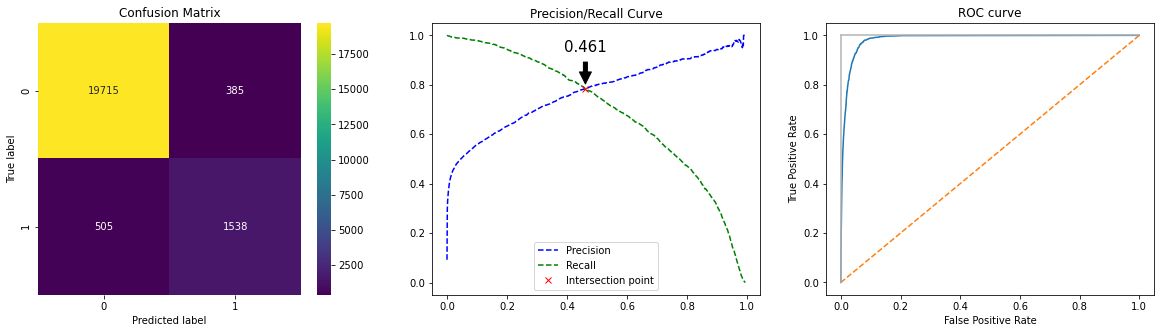

Prediction finished ...


In [62]:
model_metrics(total_test_df)
print("Prediction finished ...")

---

## <font color='blue'> 13. 결론</font>

* Test셋 중, 0의 비율이 약 91%입니다. 현재 저희 모델은 약 96%를 정확하게 예측하고 있다는 점에서 나쁘지 않은 성능을 보여주고 있습니다.
* 전기로  출강 관련 더욱 깊은 도메인 지식을 바탕으로 고도의 feature engineering을 적용해보는 방향으로 모델을 개선해볼 수 있을 것 같습니다. 
* 또한 추후 계속 데이터가 쌓인다고 하니, 이를 통해 모델 성능을 고도화해볼 수도 있을 것 같습니다.